In Context evaluation of the best performing models.

We now wish to evaluate each of our projection models at the token level. We construct an evaluation dataset from a set of homonyms from the McRae feature set. The dataset consists of tokens of homonymous words collected from the BNC, alongside gold feature data for disambiguated senses.

We then train our models on the other words in the McRae dataset, using the parameter settings from the type level. We train 

4 layer ffnn (1k)
4 layer ffnn (5k)
4 layer ffnn (glove)
plsr (1k)
plsr (5k)
plsr(glove)
label propagation (1k)
label propagation (5k)
label propagation (glove)

To evaluate a model, we use it to predict features in context for each token in the dataset. Then, we compare to the gold feature data. We also calculate the average distance between 

In [33]:
import sys
sys.path.append("../lib/")

import torch
from bert import *
from feature_data import *
from multiprototype import *
from models import *
from utils import *
from nltk.corpus import wordnet as wn
from nltk.corpus.reader.wordnet import Lemma
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib.pyplot as plt



bert = BERTBase()

INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /Users/gabriellachronis/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.modeling:extracting archive file /Users/gabriellachronis/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /var/folders/9m/vzvx58rs51v_x5nm620fz4xr0000gn/T/tmpenbzqeka
INFO:pytorch_pretrained_bert.modeling:Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 3

We want to evaluate the model on its ability to predict features in context. First, we obtain gold vectors for both senses of 10 ambiguous words from the McRae et al. data

TODO: Ensure that the models are not trained on this data. Maybe train on everything but these words?

What are the words?

In [6]:
save_path = '../trained_models/model.modabs.buchanan.allbuthomoyms.5k'
model = torch.load(save_path)

df = pd.read_csv('../bnc_contexts_for_mcrae_homonyms.csv')
feature_norms = BuchananFeatureNorms('../data/buchanan/cue_feature_words.csv')



evaluate_in_context(model, df, bert, feature_norms)

Average cosine between gold and predicted feature norms: 0.40150543059421334
Average % @k (derby metric) 0.3490627202255109
correlation between gold and predicted vectors: 0.08379081652241141 
total number of predictions:  55


In [ ]:
ambiguous_pairs = [
    ('bat_animal', 'bat_baseball'),
    ('board_wood', 'board_black'),
    ('bow_ribbon', 'bow_weapon'),
    ('cap_bottle', 'cap_hat'),
    #('crane_machine', 'crane_animal')
    ('hose', 'hose_leggings'),
    ('mink', 'mink_coat'), # this one is not fully disambiguated
    ('mouse', 'mouse_computer'),
    ('pipe_smoking', 'pipe_plumbing'),
    ('tank_army', 'tank_container')
]

In [ ]:
[item for t in ambiguous_pairs for item in t]


In [ ]:
"""
train an save best models
"""
from argparse import Namespace

"""
we dont need to do this if we've already got the model
"""

# # initialize model

# # dummy command line options
# args = Namespace(epochs=30, 
#                  lr=1e-3, 
#                  dropout=0.2, 
#                  layer = 8,
#                  clusters = 5,
#                  save_path= 'ffnn.30eps.5k.training4418.saved',
#                  batch_size=1,
#                  hidden_size = 300
#                 )

# # x data
# feature_norms = BuchananFeatureNorms('data/buchanan/cue_feature_words.csv')
# # y_hat data
# layer = 8
# clusters = 5
# embedding_file = './data/multipro_embeddings/layer'+ str(args.layer) + 'clusters' + str(args.clusters) + '.txt'
# embs = read_multiprototype_embeddings(embedding_file, layer=args.layer, num_clusters=args.clusters)



# #train_words are all feature_norms except for the above words
# #dev words are the above words
# #test words are the above words
# words = list(feature_norms.vocab.keys())
# eval_words = [item for t in ambiguous_pairs for item in t]

# print("Starting with %s words" % len(words))
# train_words = [i for i in words if i not in eval_words]
# print("Ending up with %s training words" % len(train_words))


# train
#multi_model = train_ffnn(train_words, eval_words, embs, feature_norms, args)
# save
#torch.save(model, args.save_path)
# load
multi_model = torch.load('ffnn.30eps.5k.training4418.saved')

In [ ]:
"""
train a single prototype model
"""
# embs = read_multiprototype_embeddings(embedding_file, layer=args.layer, num_clusters=1)
# single_model = train_ffnn(train_words, eval_words, embs, feature_norms, args)
# torch.save(model, 'ffnn.30eps.1k.training4418.saved')
single_model = torch.load('ffnn.30eps.1k.training4418.saved')

"""
train a glove model
"""
# embeddings_list = []
# word_indexer = Indexer()
# with open("data/glove.6B/glove.6B.300d.txt", 'r') as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         vector = np.asarray(values[1:], "float32")
#         embeddings_list.append([vector])

#         #print(embeddings_dict)
#         #raise Exception("hfelfnl")
#         word_indexer.add_and_get_index(word)

# embs = MultiProtoTypeEmbeddings(word_indexer, np.array(embeddings_list), 0, 1) # dummy layer, clusters = 1
# glove_model = train_ffnn(train_words, eval_words, embs, feature_norms, args)
# torch.save(model, 'ffnn.30eps.glove.training4418.saved')

glove_model = torch.load('ffnn.30eps.glove.training4418.saved')

In [ ]:
"""
take a look at the gold features for these words.
"""
norms = BuchananFeatureNorms('data/buchanan/cue_feature_words.csv')


norms.print_features('bat')
norms.print_features('bat_baseball')
norms.print_features('bat_animal')

Now we want to find examples of each sense and make predictions using the model for that word. We will score the predictions of each example and then average them. Here are 10 examples of bat_animal. Load these from the file we have created with these words.

In [ ]:


senses_to_analyze = {
    'bat_animal': wn.lemma('bat.n.01.bat'),
    'bat_baseball': wn.lemma('bat.n.05.bat'),
    'board_wood': wn.lemma('board.n.02.board'),
    'board_black': wn.lemma('blackboard.n.01.blackboard'),
    'bow_ribbon': wn.lemma('bow.n.08.bow'),
    'bow_weapon': wn.lemma('bow.n.04.bow'),
    'cap_bottle': wn.lemma('cap.n.02.cap'),
    'cap_hat': wn.lemma('cap.n.01.cap'),
    #('crane_machine', 'crane_animal')
    'hose': wn.lemma('hose.n.03.hose'),
    'hose_leggings': wn.lemma('hose.n.01.hose'),
    'mink': wn.lemma('mink.n.03.mink'),
    'mink_coat': wn.lemma('mink.n.01.mink'), # # this one is not fully disambiguated
    'mouse': wn.lemma('mouse.n.01.mouse'),
    'mouse_computer': wn.lemma('mouse.n.04.mouse'),
    'pipe_smoking':  wn.lemma('pipe.n.01.pipe'),
    'pipe_plumbing': wn.lemma('pipe.n.02.pipe'),
    'tank_army': wn.lemma('tank.n.01.tank'),
    'tank_container': wn.lemma('tank.n.02.tank')
}



# for k, v in senses_to_analyze.items():
#     print(v.synset())
#     print(v)

In [ ]:
from nltk.corpus import semcor
from nltk.tree import Tree
import itertools
import random


# todo check if there is hose in semcor




def traverse_tree(tree):
    # print("tree:", tree)
    for subtree in tree:
        if type(subtree) == Tree:
            print(subtree.label())
            traverse_tree(subtree)


def find_tokens(wn_lemma, sents):

    #sents = random.shuffle(sents)
    res = []
    
    for sent in sents:
        save = False
        sentence_string = []
        #print(sent)
        #for item in sent:
            #print(item.word)
        for chunk in sent:
            sense = chunk.label()
            #print(sense)
            if isinstance(sense, str):
                None
            elif sense is None:
                None
            else:
              #  print(sense.name())
    #         sense = chunk.label
    #         print(sense)
    #         print(wordnet_sense)

    #         #print(sense.type())
                if sense.key() == wn_lemma.key():
                    print("found ", sense)
                    save = True
            #print("leaves")
            #print(chunk.leaves())
            sentence_string.append(chunk.leaves())

        if save==True:
            sentence_string = list(itertools.chain(*sentence_string))
            sentence_string = ' '.join(sentence_string)
            res.append(sentence_string)
    
    return res
        
sents = semcor.tagged_sents( tag = ' sem ' )



"""
test function with three words
"""
wordnet_senses = [
                #wn.lemma('produce.v.04.produce'),
                 wn.lemma('bat.n.01.bat'),
                 wn.lemma('bat.n.05.bat'),
                 wn.lemma('mouse.n.04.mouse')
                ]

for sense in wordnet_senses:
    contexts = find_tokens(sense, sents)
    print(sense)
    print(contexts)

In [ ]:
### We really want to ensure these models are trained on everyhing but our eval words


# gold vectors, multiple sentences per word
"""
we want to take each feature cue / wordnet lemma pair and get the feature norm for the pair, 
as well as the sentences from semcor with that lemma

and just put them in a list of tuples
"""
data = []

# cue_words = []
# for w1, w2 in ambiguous_pairs:
#     cue_words.append(w1)
#     cue_words.append(w1)
# print(cue_words)

for cue_word, lemma in senses_to_analyze.items():
    print(cue_word)
    gold_vector = norms.get_feature_vector(cue_word)
    
    contexts = find_tokens(lemma, sents)
    print(contexts)
    
    for context in contexts:
        row = (cue_word, lemma, context)
        data.append(row)

In [ ]:
"""
save contexts to file
"""
with open('bnc_contexts_for_mcrae_homonyms.csv','w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['cue_word', 'lemma', 'context'])
    for cue, lemma, context in data:                
        writer.writerow([cue, lemma, context])

# Train the Models

We train a 4 layer FFNN to predict the real-valued features of each word, using buchanan (2019) feature norms as training data. We exclude only the above words, and train on all the rest. 

In [ ]:
# first prepare embeddings

# glove embeddings
glove_embeddings_list = []
glove_indexer = Indexer()
with open("data/glove.6B/glove.6B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        glove_embeddings_list.append([vector])

        #print(embeddings_dict)
        #raise Exception("hfelfnl")
        glove_indexer.add_and_get_index(word)
glove_embs = MultiProtoTypeEmbeddings(glove_word_indexer, np.array(glove_embeddings_list), 0, 1) # dummy layer, clusters = 1

# multipro embeddings
multipro_embs = read_multiprototype_embeddings(embedding_file, layer=args.layer, num_clusters=5)


# single pro embeddings
singlepro_embs = read_multiprototype_embeddings(embedding_file, layer=args.layer, num_clusters=1)


In [ ]:
# then gather the data

feature_norms = BuchananFeatureNorms('../data/buchanan/cue_feature_words.csv')


#train_words are all feature_norms except for the above words
#dev words are the above words
#test words are the above words
words = list(feature_norms.vocab.keys())
eval_words = [item for t in ambiguous_pairs for item in t]

print("Starting with %s words" % len(words))
train_words = [i for i in words if i not in eval_words]
print("Ending up with %s training words" % len(train_words))

In [ ]:
"""
train ffnn models
"""
single_model = train_ffnn(train_words, eval_words, embs, feature_norms, args)
torch.save(model, '../trained_models/ffnn.30eps.1k.training4418.saved')

"""
train a glove model
"""


# glove_model = train_ffnn(train_words, eval_words, embs, feature_norms, args)
# torch.save(model, 'ffnn.30eps.glove.training4418.saved')

glove_model = torch.load('../trained_models/ffnn.30eps.glove.training4418.saved')

In [10]:
"""
models and save paths

"""
models = [
    'trained_models/model.plsr.buchanan.allbuthomoyms.5k.300components.500max_iters',
    'trained_models/model.plsr.buchanan.allbuthomoyms.1k.300components.500max_iters',
    #'trained_models/model.plsr.buchanan.allbuthomoyms.glove.300components.300max_iters',
    'trained_models/model.ffnn.buchanan.allbuthomoyms.5k.50epochs.0.5dropout.lr1e-4.hsize300',
    'trained_models/model.ffnn.buchanan.allbuthomoyms.1k.50epochs.0.5dropout.lr1e-4.hsize300',
    #'trained_models/model.ffnn.buchanan.allbuthomoyms.glove.50epochs.0.5dropout.lr1e-4.hsize300',
    'trained_models/model.modabs.buchanan.allbuthomoyms.5k',
    'trained_models/model.modabs.buchanan.allbuthomoyms.1k',
    #'trained_models/model.modabs.buchanan.allbuthomoyms.glove'
]

# Run the models on the data

In [11]:
df = pd.read_csv('../data/bnc_contexts_for_mcrae_homonyms.csv')
df

,cue_word,lemma,context
0,bat_animal,Lemma('bat.n.01.bat'),Or the surging whirling sounds of bats at nigh...
1,bat_animal,Lemma('bat.n.01.bat'),"Out of the church and into his big car , it to..."
2,board_wood,Lemma('board.n.02.board'),He just shot at the board and then drew circle...
3,board_wood,Lemma('board.n.02.board'),Then I cover the sowing with a board .
4,board_wood,Lemma('board.n.02.board'),When the first sprinkling of green appears I r...
5,board_wood,Lemma('board.n.02.board'),Standing in the shelter of the tent - a reject...
6,board_wood,Lemma('board.n.02.board'),"Beyond that misty gray of the rain , he saw th..."
7,board_wood,Lemma('board.n.02.board'),"Over the door was a board with large , inept l..."
8,board_wood,Lemma('board.n.02.board'),"With enormous interest , Adam watched his hand..."
9,board_wood,Lemma('board.n.02.board'),Alley fences were made of solid boards higher ...


In [12]:
string = "Synset('tank.n.02.tank')"
re.findall(r"'(.*?)'", string)[0]

'tank.n.02.tank'

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

from scipy.stats import spearmanr

"""
data is a list of tuples of (cue word, lemma, context)

for each model, we want to run an analysis of these
"""

def pluralize(string):
    if string == 'mouse':
        return 'mice'
    else:
        return string + 's'

# def predict_logits_and_features_in_context(model, cue_word, lemma, context, bert):
#     """
#     returns tuple containing
#     """

def evaluate_in_context(model, df, bert, norms):
    n = 0

    correlations = []
    cosines = []
    top_k_precs = []

    for index, row in df.iterrows():
        cue_word = row.cue_word        
        lemma = re.findall(r"'(.*?)'", row.lemma)[0]
        lemma = wn.lemma(lemma)
        context = row.context
        
        n +=1


        gold_vector = norms.get_feature_vector(singular)
        gold_feats = norms.get_features(singular)
        k = len(gold_feats)


        singular = lemma.name()
        plural = pluralize(singular)
        try:
            predicted_vector = model.predict_in_context(singular, context, bert)
            top_k =  model.predict_top_n_features_in_context(singular, context, k, bert)
        except:
            predicted_vector = model.predict_in_context(plural, context, bert)
            top_k =  model.predict_top_n_features_in_context(plural, context, k, bert=bert)

        cos = 1 - cosine(predicted_vector, gold_vector)
        cosines.append(cos)      

        num_in_top_k = len(set(top_k).intersection(set(gold_feats)))
        top_k_prec = num_in_top_k / k
        top_k_precs.append(top_k_prec)

        corr, p = spearmanr(predicted_vector, gold_vector)
        correlations.append(corr)

        #print("cosine: %f" % cos)
        #print("precison: %f" % prec)
        #print("correlation: %f" % corr)
        #print("top k acc: %f" % top_k_prec)

    print("Average cosine between gold and predicted feature norms: %s" % np.average(cosines))
    #print("average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector: ", top_10_prec)
    #print("average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector: ", top_20_prec)
    print("Average % @k (derby metric)", np.average(top_k_precs))
    #print("Percentage (%) of test items that retrieve their gold-standard vector in the top 10 neighbours of their predicted vector: %f" % top_20_acc)
    print("correlation between gold and predicted vectors: %s " % np.average(correlations))

    print("total number of predictions: ", n)
    



In [14]:
feature_norms = BuchananFeatureNorms('../data/buchanan/cue_feature_words.csv')


for save_path in models:
    print("****************************************")
    print("*** Evaluating %s model ***" % save_path)
    print("****************************************")
    model = torch.load(save_path)

    evaluate_in_context(model, df, bert, feature_norms)

****************************************
*** Evaluating trained_models/model.plsr.buchanan.allbuthomoyms.5k.300components.500max_iters model ***
****************************************
Average cosine between gold and predicted feature norms: 0.35884764922915174
Average % @k (derby metric) 0.37267609651330585
correlation between gold and predicted vectors: 0.08174618006523028 
total number of predictions:  55
****************************************
*** Evaluating trained_models/model.plsr.buchanan.allbuthomoyms.1k.300components.500max_iters model ***
****************************************
Average cosine between gold and predicted feature norms: 0.32875389037802444
Average % @k (derby metric) 0.3507248565388101
correlation between gold and predicted vectors: 0.07935979478438276 
total number of predictions:  55
****************************************
*** Evaluating trained_models/model.ffnn.buchanan.allbuthomoyms.5k.50epochs.0.5dropout.lr1e-4.hsize300 model ***
*********************

# Correlate predicted features with wu-palmer similarity

use homonym token dataset
 lemma cue_word context 
 
add label row to df

Get predictions on 

In [15]:
df = pd.read_csv('../data/bnc_contexts_for_mcrae_homonyms.csv')
df

,cue_word,lemma,context
0,bat_animal,Lemma('bat.n.01.bat'),Or the surging whirling sounds of bats at nigh...
1,bat_animal,Lemma('bat.n.01.bat'),"Out of the church and into his big car , it to..."
2,board_wood,Lemma('board.n.02.board'),He just shot at the board and then drew circle...
3,board_wood,Lemma('board.n.02.board'),Then I cover the sowing with a board .
4,board_wood,Lemma('board.n.02.board'),When the first sprinkling of green appears I r...
5,board_wood,Lemma('board.n.02.board'),Standing in the shelter of the tent - a reject...
6,board_wood,Lemma('board.n.02.board'),"Beyond that misty gray of the rain , he saw th..."
7,board_wood,Lemma('board.n.02.board'),"Over the door was a board with large , inept l..."
8,board_wood,Lemma('board.n.02.board'),"With enormous interest , Adam watched his hand..."
9,board_wood,Lemma('board.n.02.board'),Alley fences were made of solid boards higher ...


In [27]:
ws = []
wn_lemmas = []
for index, row in df.iterrows():
    lemma = re.findall(r"'(.*?)'", row.lemma)[0]
    lemma = wn.lemma(lemma)
    
    word = lemma.name()
    #print(word)
    ws.append(word)
    wn_lemmas.append(lemma)
    
df['label'] = ws
df['wn_lemma'] = wn_lemmas

df


,cue_word,lemma,context,label,wn_lemma
0,bat_animal,Lemma('bat.n.01.bat'),Or the surging whirling sounds of bats at nigh...,bat,Lemma('bat.n.01.bat')
1,bat_animal,Lemma('bat.n.01.bat'),"Out of the church and into his big car , it to...",bat,Lemma('bat.n.01.bat')
2,board_wood,Lemma('board.n.02.board'),He just shot at the board and then drew circle...,board,Lemma('board.n.02.board')
3,board_wood,Lemma('board.n.02.board'),Then I cover the sowing with a board .,board,Lemma('board.n.02.board')
4,board_wood,Lemma('board.n.02.board'),When the first sprinkling of green appears I r...,board,Lemma('board.n.02.board')
5,board_wood,Lemma('board.n.02.board'),Standing in the shelter of the tent - a reject...,board,Lemma('board.n.02.board')
6,board_wood,Lemma('board.n.02.board'),"Beyond that misty gray of the rain , he saw th...",board,Lemma('board.n.02.board')
7,board_wood,Lemma('board.n.02.board'),"Over the door was a board with large , inept l...",board,Lemma('board.n.02.board')
8,board_wood,Lemma('board.n.02.board'),"With enormous interest , Adam watched his hand...",board,Lemma('board.n.02.board')
9,board_wood,Lemma('board.n.02.board'),Alley fences were made of solid boards higher ...,board,Lemma('board.n.02.board')


In [42]:
def run_wu_palmer_analysis(df):
    """
    input is a dataframe with columns
        cue_word
        lemma
        context
        label
    """
    wup_sims = []
    cossine_sims = []

    for index, row in df.iterrows():
        word = row.label

        # select other examples of this token
        othertokens = df[df.label == word]
        # filter out the token itself
        othertokens = othertokens[othertokens.index != index]
        #print(othertokens)

        for index, otherword in othertokens.iterrows():
            # find the wordnet distance between these two wordnet senses
            synset1 = row.wn_lemma.synset()
            synset2 = otherword.wn_lemma.synset()

            wup_sim = synset1.wup_similarity(synset2)
            wup_sims.append(wup_sim)
            cossim = 1 - cosine(row.predictions, otherword.predictions)
            #cossim = 1 - cosine(row.single_prototype_model_preds, otherword.single_prototype_model_preds)
            cossine_sims.append(cossim)
            #print(synset1)
            #print(synset2)
            #print(wup_sim)
            #print(cossim)
    return (wup_sims, cossine_sims)

def plot_sims(wup_sims, cossine_sims):
    plt.scatter(wup_sims, cossine_sims)
    plt.title("Wordnet similarity of homonymous senses plotted against cosine similarity of predicted vectors of two tokens in semantic feature space")
    plt.xlabel("Wu and Palmer Similarity")
    plt.ylabel("Cosine Similarity")
    plt.show()

****************************************
*** doing wu palmer correlation for trained_models/model.plsr.buchanan.allbuthomoyms.5k.300components.500max_iters ***
****************************************


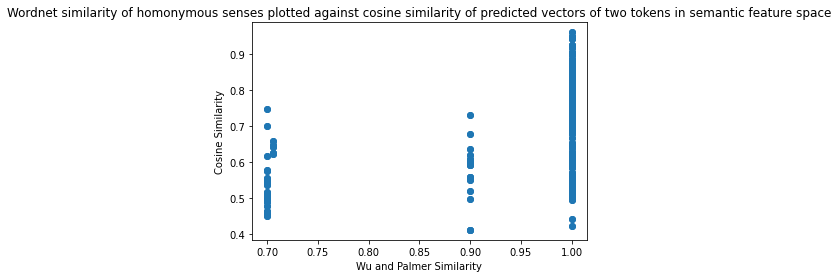

Pearsons correlation: 0.454, p-value: 7.311136794681757e-28
Spearmans correlation: 0.473, p-value: 2.0635281425761226e-30
****************************************
*** doing wu palmer correlation for trained_models/model.plsr.buchanan.allbuthomoyms.1k.300components.500max_iters ***
****************************************


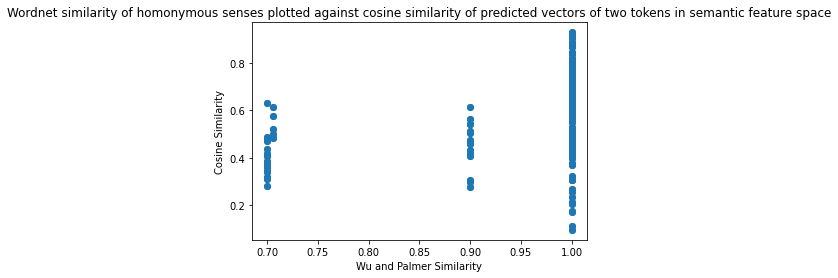

Pearsons correlation: 0.423, p-value: 4.9166661965110344e-24
Spearmans correlation: 0.482, p-value: 1.1396951575555852e-31
****************************************
*** doing wu palmer correlation for trained_models/model.ffnn.buchanan.allbuthomoyms.5k.50epochs.0.5dropout.lr1e-4.hsize300 ***
****************************************


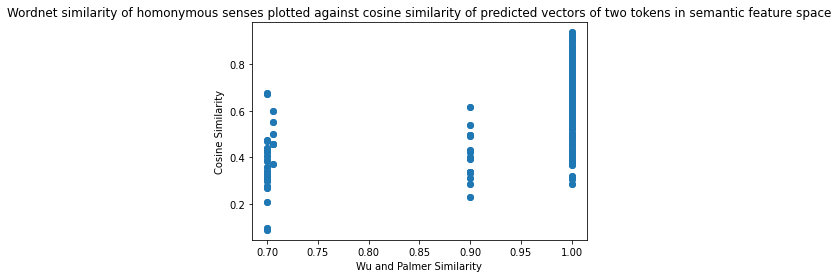

Pearsons correlation: 0.552, p-value: 7.638203287879455e-43
Spearmans correlation: 0.540, p-value: 9.289357155683687e-41
****************************************
*** doing wu palmer correlation for trained_models/model.ffnn.buchanan.allbuthomoyms.1k.50epochs.0.5dropout.lr1e-4.hsize300 ***
****************************************


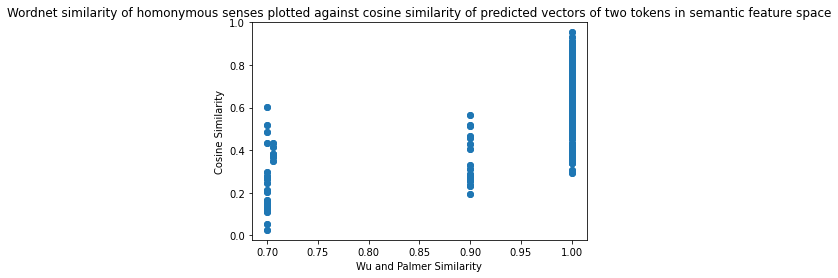

Pearsons correlation: 0.660, p-value: 3.221152860246388e-66
Spearmans correlation: 0.587, p-value: 2.090046026964229e-49
****************************************
*** doing wu palmer correlation for trained_models/model.modabs.buchanan.allbuthomoyms.5k ***
****************************************


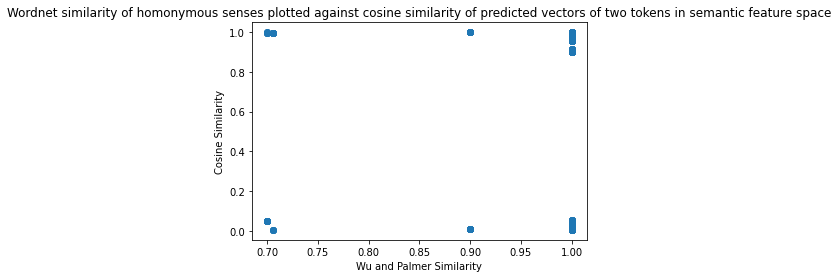

Pearsons correlation: 0.253, p-value: 4.952474988939253e-09
Spearmans correlation: 0.167, p-value: 0.00012435558282395312
****************************************
*** doing wu palmer correlation for trained_models/model.modabs.buchanan.allbuthomoyms.1k ***
****************************************


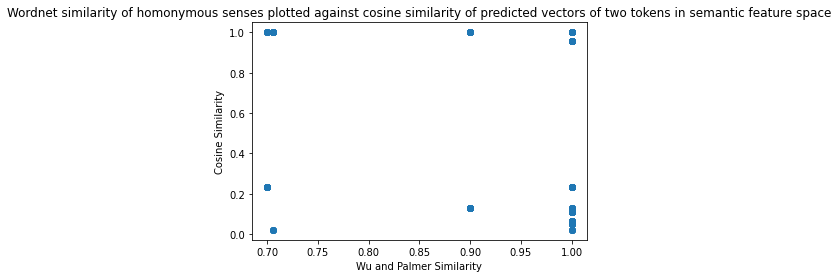

Pearsons correlation: 0.270, p-value: 4.0963340074493193e-10
Spearmans correlation: 0.186, p-value: 2.0687755208304317e-05


In [43]:
"""
create a list of predicted feature vectors for each of the models being evaluated
and then stick them in the dataframe
"""

for save_path in models:
    print("****************************************")
    print("*** doing wu palmer correlation for %s ***" % save_path)
    print("****************************************")
    model = torch.load(save_path)
    
    predictions = []
    for index, row in df.iterrows():
            singular = row.wn_lemma.name()
            plural = pluralize(singular)

            try:
                predicted_vector = model.predict_in_context(singular, row.context, bert)
            except:
                predicted_vector = model.predict_in_context(plural, row.context, bert)


            predictions.append(predicted_vector)

    df['predictions'] = predictions
    
    wup_sims, cossine_sims = run_wu_palmer_analysis(df)
    plot_sims(wup_sims, cossine_sims)

    corr, p = pearsonr(wup_sims, cossine_sims)
    print('Pearsons correlation: %.3f, p-value: %s'  % (corr, p))

    corr, p = spearmanr(wup_sims, cossine_sims)
    print('Spearmans correlation: %.3f, p-value: %s'  % (corr, p))

# Do the same analysis for single-prototype model

In [32]:
wup_sims = []
cossine_sims = []

for index, row in df.iterrows():
    word = row.label
    
    # select other examples of this token
    othertokens = df[df.label == word]
    # filter out the token itself
    othertokens = othertokens[othertokens.index != index]
    #print(othertokens)
    
    for index, otherword in othertokens.iterrows():
        # find the wordnet distance between these two wordnet senses
        synset1 = row.wn_lemma.synset()
        synset2 = otherword.wn_lemma.synset()
        
        wup_sim = synset1.wup_similarity(synset2)
        wup_sims.append(wup_sim)
        cossim = 1 - cosine(row.predictions, otherword.predictions)
        cossine_sims.append(cossim)
        #print(synset1)
        #print(synset2)
        #print(wup_sim)
        #print(cossim)

# calculate Pearson's correlation
from scipy.stats import pearsonr
from scipy.stats import spearmanr


corr, p = pearsonr(wup_sims, cossine_sims)
print('Pearsons correlation: %.3f, p-value: %s'  % (corr, p))

corr, p = spearmanr(wup_sims, cossine_sims)
print('Spearmans correlation: %.3f, p-value: %s'  % (corr, p))  

"""
do the correlation:
"""
import matplotlib.pyplot as plt

pyplot.scatter
pyplot.show()

plt.scatter(wup_sims, cossine_sims)
plt.title("Wordnet similarity of homonymous senses plotted against cosine similarity of predicted vectors of two tokens in semantic feature space")
plt.xlabel("Wu and Palmer Similarity")
plt.ylabel("Cosine Similarity")
plt.show()

Pearsons correlation: 0.454, p-value: 7.311136794681757e-28
Spearmans correlation: 0.473, p-value: 2.0635281425761226e-30


NameError: name 'pyplot' is not defined

# Run the analysis for the non-contextual model (trained on GloVe)

Here we expect to see no correlation, because the model should be making the same prediction for every token of a word form, irrespective of the surrounding context

In [ ]:
"""
first we need to make the predictions, which we havent generated yet. we already have a trained model, called 'glove_model'
"""

correlations = []
cosines = []
top_k_precs = []
n = 0

glove_model_predictions = []

for cue_word, lemma, context in data:
    n +=1
    singular = lemma.name()
    plural = pluralize(singular)

    gold_vector = norms.get_feature_vector(singular)
    gold_feats = norms.get_features(singular)
    k = len(gold_feats)



    try:
        predicted_vector = glove_model.predict(singular)
        top_k =  glove_model.predict_top_n_features(singular, k)
    except:
        predicted_vector = glove_model.predict(plural)
        top_k =  glove_model.predict_top_n_features(plural, k)

    glove_model_predictions.append(predicted_vector)
    cos = 1 - cosine(predicted_vector, gold_vector)
    cosines.append(cos)      

    #num_in_top_k = len(set(top_k).intersection(set(gold_feats)))
    #top_k_prec = num_in_top_k / k
    #top_k_precs.append(top_k_prec)

    corr, p = spearmanr(predicted_vector, gold_vector)
    correlations.append(corr)

    #print("cosine: %f" % cos)
    #print("precison: %f" % prec)
    #print("correlation: %f" % corr)
    #print("top k acc: %f" % top_k_prec)

print("Average cosine between gold and predicted feature norms: %s" % np.average(cosines))
#print("average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector: ", top_10_prec)
#print("average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector: ", top_20_prec)
#print("Average % @k (derby metric)", np.average(top_k_precs))
#print("Percentage (%) of test items that retrieve their gold-standard vector in the top 10 neighbours of their predicted vector: %f" % top_20_acc)
print("correlation between gold and predicted vectors: %s " % np.average(correlations))

print("total number of predictions: ", n)


df['glove_predictions'] = glove_model_predictions

#df


In [ ]:
wup_sims = []
cossine_sims = []

for index, row in df.iterrows():
    word = row.label
    
    # select other examples of this token
    othertokens = df[df.label == word]
    # filter out the token itself
    othertokens = othertokens[othertokens.index != index]
    #print(othertokens)
    
    for index, otherword in othertokens.iterrows():
        # find the wordnet distance between these two wordnet senses
        synset1 = row.lemma.synset()
        synset2 = otherword.lemma.synset()
        
        wup_sim = synset1.wup_similarity(synset2)
        wup_sims.append(wup_sim)
        cossim = 1- cosine(row.glove_predictions, otherword.glove_predictions)
        cossine_sims.append(cossim)
        #print(synset1)
        #print(synset2)
        #print(wup_sim)
        #print(cossim)

# calculate Pearson's correlation
from scipy.stats import pearsonr
from scipy.stats import spearmanr


corr, p = pearsonr(wup_sims, cossine_sims)
print('Pearsons correlation: %.3f, p-value: %s'  % (corr, p))

corr, p = spearmanr(wup_sims, cossine_sims)
print('Spearmans correlation: %.3f, p-value: %s'  % (corr, p))  

"""
do the correlation:
"""
import matplotlib.pyplot as plt

pyplot.scatter
pyplot.show()

plt.scatter(wup_sims, cossine_sims)
plt.title("Wordnet similarity of homonymous senses plotted against cosine similarity of predicted vectors of two tokens in semantic feature space")
plt.xlabel("Wu and Palmer Similarity")
plt.ylabel("Cosine Similarity")
plt.show()

In [ ]:
embeddings_list = []
word_indexer = Indexer()
with open("../data/glove.6B/glove.6B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_list.append([vector])

        #print(embeddings_dict)
        #raise Exception("hfelfnl")
        word_indexer.add_and_get_index(word)

embs = MultiProtoTypeEmbeddings(word_indexer, np.array(embeddings_list), 0, 1)
